In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
sns.set()

import sklearn
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

## Pretty variable display 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## RANDOM STATE
seed=3

In [2]:
df = pd.read_csv('../datasets/master_5man_lineup_clusters_2000_2020.csv', index_col=0)
df.shape
df.head()

(1682, 51)

,mp,diff_pts,diff_fg,diff_fga,diff_fg_pct,diff_fg3,diff_fg3a,diff_fg3_pct,diff_efg_pct,diff_ft,...,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11
lineup,,,,,,,,,,,,,,,,,,,,,
B. Coles | A. Henderson | J. Jackson | D. Mutombo | I. Rider ATL 2000,869.000000,-1.2,-0.8,-3.5,0.008,-1.7,-4.0,-0.002,0.000,2.0,...,0.914418,0.000282,0.000000,0.000359,1.999455,1.0,0.000005,0.000000,0.999653,0.000000
A. Henderson | J. Jackson | R. McLeod | D. Mutombo | J. Terry ATL 2000,294.000000,-16.1,-7.2,-3.8,-0.058,-2.1,-3.0,-0.090,-0.069,0.3,...,0.914418,0.000282,0.000000,0.960006,1.036375,1.0,0.000005,0.000000,0.999010,0.000016
L. Ellis | A. Henderson | J. Jackson | D. Mutombo | J. Terry ATL 2000,217.866667,-4.0,-3.5,-2.4,-0.026,1.0,1.4,0.045,-0.020,2.1,...,0.914418,0.000282,0.000000,0.960006,1.036375,1.0,0.006180,0.000000,0.996896,0.000016
M. Maloney | R. McLeod | D. Mutombo | J. Terry | L. Wright ATL 2001,238.566667,9.4,4.5,3.6,0.031,-1.2,-5.6,0.053,0.024,1.7,...,0.000002,0.000000,0.000000,0.997453,1.000015,1.0,0.000000,0.000000,1.000001,0.002531
S. Abdur-Rahim | D. Johnson | N. Mohammed | I. Newble | J. Terry ATL 2002,450.983333,1.4,-1.2,-0.9,-0.009,0.6,0.1,0.041,-0.006,3.2,...,0.993295,0.957872,0.000002,0.000000,0.000074,1.0,0.996992,0.048741,0.007007,0.000017


## High correlations with `diff_pts`

In [3]:
df.dtypes.value_counts()
df.select_dtypes('O').columns

float64    47
object      2
int64       2
dtype: int64

Index(['player_ids', 'team'], dtype='object')

<AxesSubplot:>

Text(0.5, 1.0, '10 lineup stats most correlated with point differential')

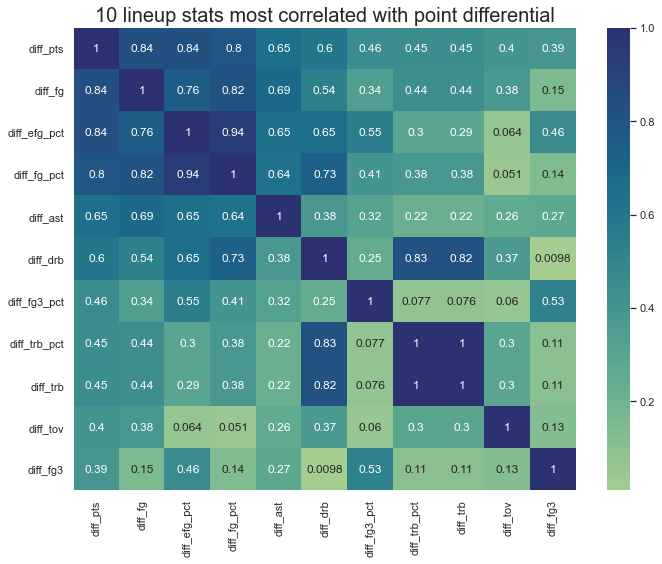

In [138]:
corr_mat = df.corr().abs()
corr_diff_pts = corr_mat.loc[['diff_pts'], :].T
corr_diff_pts = corr_diff_pts.sort_values(by='diff_pts', ascending=False)
high_corr_diff_pts = corr_diff_pts[0:11]
high_corr_cols = high_corr_diff_pts.T.columns
high_corr_mat = corr_mat.loc[high_corr_cols, high_corr_cols]

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(high_corr_mat, ax=ax, cmap='crest', annot=True)

ax.set_title('10 lineup stats most correlated with point differential', fontsize=20)
plt.tight_layout()
fig.savefig('../plots/lineup_10_correlated_stats_diff_pts.png')

## Add total lineup salary in dollars

### Goal is to get a salary total and then correlate salary to diff pts and other things as well 

In [7]:
df_players = pd.read_csv('../datasets/master_players_stats_bio_clusters_pca.csv', index_col=0)
df_players.shape
# df_players.head()

(6541, 145)

In [8]:
## no salary info for 2020, remove
df_players_salary = df_players[df_players['year']<2020].copy()
df_players_salary.shape

(6225, 145)

In [9]:
df_players_salary.isna().sum().sort_values(ascending=False)

salary                     36
fg_pct_corner3              0
fouls_offensive_per_min     0
drawn_shooting_per_min      0
astd_pts_per_min            0
                           ..
cluster_4                   0
cluster_3                   0
cluster_2                   0
cluster_1                   0
player_id                   0
Length: 145, dtype: int64

In [73]:
df_players_salary.dropna(axis=0, inplace=True)
df_players_salary.shape
df_players_salary.isna().sum().sort_values(ascending=False)

(6189, 145)

pc_28                     0
fg3_pct                   0
drawn_shooting_per_min    0
astd_pts_per_min          0
and1s_per_min             0
                         ..
cluster_3                 0
cluster_2                 0
cluster_1                 0
cluster_0                 0
player_id                 0
Length: 145, dtype: int64

### Now have player df to build lineup total salary

In [74]:
def get_lineup_salary(lineup, df_players):
    player_ids = lineup['player_ids'].split(', ')
    year = lineup['year']
    total_salary = 0
    for pid in player_ids:
        player = df_players[(df_players['year']==year) & (df_players['player_id']==pid)]
        total_salary += player['salary'].item()
    return total_salary

def check_if_valid_lineup(lineup, df_players):
    player_ids = lineup['player_ids'].split(', ')
    year = lineup['year']    
    for pid in player_ids:
        if df_players[(df_players['player_id']==pid) & (df_players['year']==year)].empty:
            return False
    return True


## filter lineups with valid player groups

In [12]:
df = pd.read_csv('../datasets/master_5man_lineup_clusters_2000_2020.csv', index_col=0)
df.shape

valid_indices = df.apply(lambda lineup: check_if_valid_lineup(lineup, df_players_salary), axis=1)
df_line_valid = df[valid_indices].copy()
df_line_valid.shape

(1682, 51)

(1619, 51)

In [13]:
lineup_salaries = df_line_valid.apply(lambda lineup: get_lineup_salary(lineup, df_players), axis=1)

In [14]:
lineup_salaries.shape
lineup_salaries

(1619,)

lineup
B. Coles | A. Henderson | J. Jackson | D. Mutombo | I. Rider ATL 2000      27773686.0
A. Henderson | J. Jackson | R. McLeod | D. Mutombo | J. Terry ATL 2000     22447366.0
L. Ellis | A. Henderson | J. Jackson | D. Mutombo | J. Terry ATL 2000      23457606.0
M. Maloney | R. McLeod | D. Mutombo | J. Terry | L. Wright ATL 2001        23697680.0
S. Abdur-Rahim | E. Davis | D. Glover | N. Mohammed | J. Terry ATL 2002    19182650.0
                                                                              ...    
B. Beal | T. Frazier | M. Gortat | M. Morris | O. Porter WAS 2018          71331365.0
T. Frazier | I. Mahinmi | J. Meeks | K. Oubre | M. Scott WAS 2018          25516063.0
I. Mahinmi | J. Meeks | K. Oubre | T. Satoranský | M. Scott WAS 2018       26516063.0
T. Ariza | B. Beal | T. Bryant | J. Green | T. Satoranský WAS 2019         47335578.0
T. Ariza | B. Beal | J. Green | B. Portis | T. Satoranský WAS 2019         48451682.0
Length: 1619, dtype: float64

### Need to scale by percentile for each year

In [15]:
df_line_valid.index.equals(lineup_salaries.index)

True

In [295]:
# a = pd.DataFrame({'a':[1,2,3]}, index=['b','c', 'd'])
# b = pd.DataFrame({'a':[1,2,3]}, index=['d','c', 'b'])
# a.index.equals(b.index)

False

In [16]:
df_line_valid['total_salary'] = lineup_salaries
df_line_valid['total_salary']

lineup
B. Coles | A. Henderson | J. Jackson | D. Mutombo | I. Rider ATL 2000      27773686.0
A. Henderson | J. Jackson | R. McLeod | D. Mutombo | J. Terry ATL 2000     22447366.0
L. Ellis | A. Henderson | J. Jackson | D. Mutombo | J. Terry ATL 2000      23457606.0
M. Maloney | R. McLeod | D. Mutombo | J. Terry | L. Wright ATL 2001        23697680.0
S. Abdur-Rahim | E. Davis | D. Glover | N. Mohammed | J. Terry ATL 2002    19182650.0
                                                                              ...    
B. Beal | T. Frazier | M. Gortat | M. Morris | O. Porter WAS 2018          71331365.0
T. Frazier | I. Mahinmi | J. Meeks | K. Oubre | M. Scott WAS 2018          25516063.0
I. Mahinmi | J. Meeks | K. Oubre | T. Satoranský | M. Scott WAS 2018       26516063.0
T. Ariza | B. Beal | T. Bryant | J. Green | T. Satoranský WAS 2019         47335578.0
T. Ariza | B. Beal | J. Green | B. Portis | T. Satoranský WAS 2019         48451682.0
Name: total_salary, Length: 1619, dtype: float6

### Convert to z-scores

In [17]:
line_year_groups = df_line_valid.groupby('year')
yearly_salary_mu_sigma = line_year_groups['total_salary'].agg(['mean', 'std'])
yearly_salary_mu_sigma

,mean,std
year,,
2000,2.576175e+07,9.774535e+06
2001,2.845078e+07,9.688395e+06
2002,2.820306e+07,9.718713e+06
2003,2.939772e+07,9.565163e+06
2004,2.922769e+07,1.059221e+07
2005,3.173350e+07,9.778641e+06
2006,3.333093e+07,8.433753e+06
2007,3.542508e+07,8.946053e+06
2008,3.689363e+07,1.161077e+07


In [18]:
def get_lineup_salary_zscore(lineup, yearly_salary_mu_sigma):
    year = lineup['year']    
    mu, sigma = yearly_salary_mu_sigma.loc[year].values
    return (lineup['total_salary'] - mu) / sigma

In [19]:
df_line_valid['salary_zscore'] = df_line_valid.apply(lambda lineup: get_lineup_salary_zscore(lineup, yearly_salary_mu_sigma), axis=1)

In [20]:
df_line_valid[['salary_zscore', 'total_salary']][0:25]

,salary_zscore,total_salary
lineup,,
B. Coles | A. Henderson | J. Jackson | D. Mutombo | I. Rider ATL 2000,0.205834,27773686.0
A. Henderson | J. Jackson | R. McLeod | D. Mutombo | J. Terry ATL 2000,-0.339084,22447366.0
L. Ellis | A. Henderson | J. Jackson | D. Mutombo | J. Terry ATL 2000,-0.235730,23457606.0
M. Maloney | R. McLeod | D. Mutombo | J. Terry | L. Wright ATL 2001,-0.490597,23697680.0
S. Abdur-Rahim | E. Davis | D. Glover | N. Mohammed | J. Terry ATL 2002,-0.928148,19182650.0
S. Abdur-Rahim | D. Glover | T. Ratliff | G. Robinson | J. Terry ATL 2003,0.622104,35348246.0
S. Abdur-Rahim | I. Newble | T. Ratliff | G. Robinson | J. Terry ATL 2003,0.517885,34351369.0
S. Abdur-Rahim | D. Glover | I. Newble | T. Ratliff | J. Terry ATL 2003,-0.347306,26075681.0
S. Abdur-Rahim | D. Glover | S. Jackson | T. Ratliff | J. Terry ATL 2004,0.449566,33989583.0


## Create histogram plot of zscores and point differential

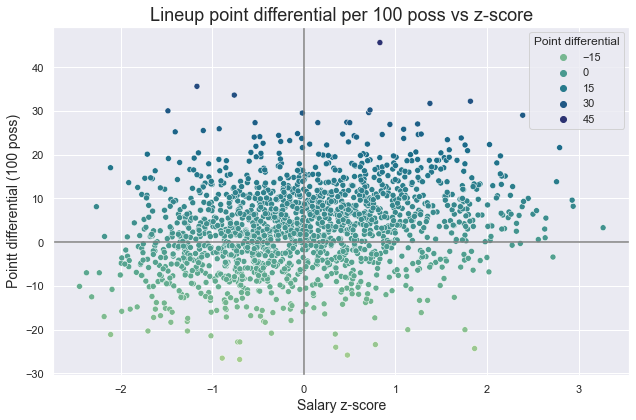

In [72]:
fig, ax = plt.subplots(figsize=(9,6))

sns.scatterplot(x='salary_zscore', y='diff_pts', data=df_line_valid, ax=ax, hue='diff_pts', palette='crest')
ax.set_title('Lineup point differential per 100 poss vs z-score', fontsize=18)
ax.set_xlabel('Salary z-score', fontsize=14)
ax.set_ylabel('Pointt differential (100 poss)', fontsize=14)
ax.legend(title='Point differential', loc='upper right')

# sns.lineplot(x=0, ax=ax)
# plt.plot([0, 0], [0, max(df_line_valid['diff_pts'])])
plt.axvline(0, 0, color='gray')
plt.axhline(0,0, color='gray')

plt.tight_layout()
fig.savefig('../plots/lineup_pts_diff_salary_zscores.png');

In [67]:
df_line_valid['diff_pts'].sort_values()

lineup
B. Gordon | J. Jerebko | B. Knight | G. Monroe | T. Prince DET 2012       -26.8
M. Blaylock | J. Caffey | A. Foyle | L. Hughes | D. Marshall GSW 2000     -26.5
K. Bryant | J. Clarkson | R. Hibbert | J. Randle | L. Williams LAL 2016   -25.8
S. Dalembert | A. Iguodala | A. Iverson | K. Ollie | C. Webber PHI 2006   -24.3
K. Bryant | J. Clarkson | R. Hibbert | J. Randle | D. Russell LAL 2016    -24.0
                                                                           ... 
A. Bogut | S. Curry | D. Green | A. Iguodala | K. Thompson GSW 2016        31.7
K. Irving | L. James | D. Liggins | K. Love | T. Thompson CLE 2017         32.2
B. Bowen | T. Duncan | M. Ginóbili | T. Parker | M. Rose SAS 2003          33.6
Ö. Aşık | L. Deng | T. Gibson | K. Korver | J. Lucas III CHI 2012          35.6
H. Barnes | S. Curry | D. Green | A. Iguodala | K. Thompson GSW 2016       45.6
Name: diff_pts, Length: 1619, dtype: float64

### Bad teams often have high salaries to clear room in the future... harder to pay to win in NBA

## Do best lineups have some coorelation with cluster stuff?

### Take best and worst 10% of lineups and check correlations with cluster cols and diff_pts

In [112]:
df = pd.read_csv('../datasets/master_4man_lineup_clusters_2000_2020.csv', index_col=0)
best_lineups = df.sort_values(by='diff_pts', ascending=False).iloc[0:(len(df)//5)]
worst_lineups = df.sort_values(by='diff_pts').iloc[0:(len(df)//5)]
best_lineups.shape
# best_lineups.head()
worst_lineups.shape
# worst_lineups.head()

(1044, 51)

(1044, 51)

### Run correlation against diff_pts

<AxesSubplot:>

Text(0.5, 1.0, 'Top 10% 4man lineups cluster correlations')

<AxesSubplot:>

Text(0.5, 1.0, 'Bottom 10% 4man lineups cluster correlations')

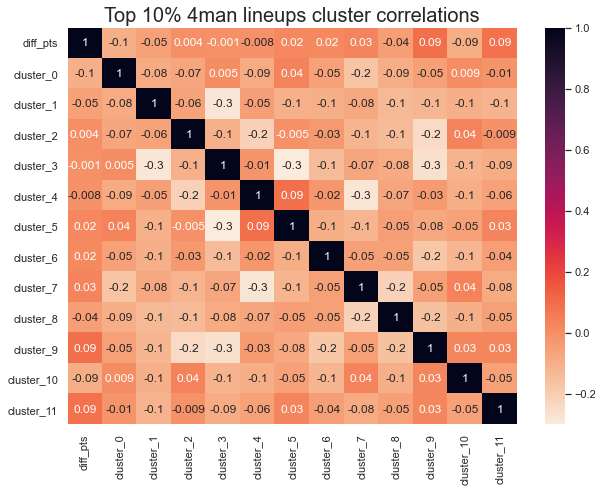

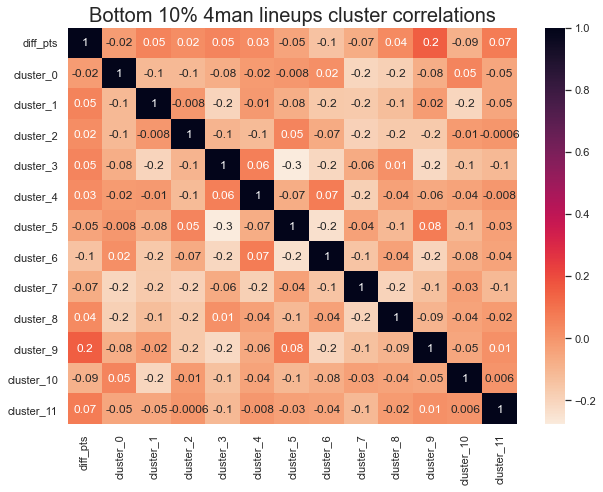

In [133]:
bpm_cols = [f'cluster_{n}_bpm' for n in range(12)]
cluster_cols = [f'cluster_{n}' for n in range(12)]

best_corr_mat = best_lineups[['diff_pts']+cluster_cols].corr()
worst_corr_mat = worst_lineups[['diff_pts']+cluster_cols].corr()

# corr_mat = best_lineups[['diff_pts']+bpm_cols].corr().abs()
# sns.heatmap(corr_mat, cmap='crest');
# corr_mat

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(best_corr_mat, ax=ax, cmap='rocket_r', annot=True, fmt='.1g')
ax.set_title('Top 10% 4man lineups cluster correlations', fontsize=20)
plt.tight_layout()
fig.savefig('../plots/top_lineups_cluster_corr.png')

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(worst_corr_mat, ax=ax, cmap='rocket_r', annot=True, fmt='.1g')
ax.set_title('Bottom 10% 4man lineups cluster correlations', fontsize=20)
plt.tight_layout()

fig.savefig('../plots/bottom_lineups_cluster_corr.png')

## Worksheet

In [68]:
df_line_valid[['salary_zscore', 'total_salary', 'diff_pts']].sort_values(by='salary_zscore', ascending=False)

,salary_zscore,total_salary,diff_pts
lineup,,,
M. World Peace | K. Bryant | P. Gasol | D. Howard | S. Nash LAL 2013,3.268658,82544469.0,3.3
S. Pippen | A. Sabonis | S. Smith | D. Stoudamire | R. Wallace POR 2001,2.941584,56950000.0,8.2
D. Anderson | D. Davis | S. Pippen | R. Wallace | B. Wells POR 2003,2.930353,57427024.0,9.6
D. Anderson | D. Davis | R. Patterson | S. Pippen | R. Wallace POR 2003,2.793586,56118824.0,21.6
S. Pippen | A. Sabonis | S. Smith | D. Stoudamire | R. Wallace POR 2000,2.759965,52739123.0,13.8
...,...,...,...
P. Brezec | M. Ely | R. Felton | J. Jones | B. Knight CHA 2006,-2.235961,14473387.0,-7.0
J. Childress | A. Johnson | Z. Pachulia | J. Smith | M. Williams ATL 2007,-2.267561,15139360.0,8.1
P. Brezec | B. Knight | E. Okafor | K. Rush | G. Wallace CHA 2005,-2.319371,9053205.0,-12.5


In [75]:
yearly_salary_mu_sigma

,mean,std
year,,
2000,2.576175e+07,9.774535e+06
2001,2.845078e+07,9.688395e+06
2002,2.820306e+07,9.718713e+06
2003,2.939772e+07,9.565163e+06
2004,2.922769e+07,1.059221e+07
2005,3.173350e+07,9.778641e+06
2006,3.333093e+07,8.433753e+06
2007,3.542508e+07,8.946053e+06
2008,3.689363e+07,1.161077e+07


In [221]:
## Test func
l1 = df_line_valid.iloc[0]
'total salary:', l1['total_salary']
year = l1['year']
'year', year
print()

mu,sigma = yearly_salary_mu_sigma.loc[year].values
mu
sigma

z = (l1['total_salary'] - mu) / sigma
z
zscore = get_lineup_salary_zscore(l1, yearly_salary_mu_sigma)
zscore

('total salary:', 27773686.0)

('year', 2000)

25761752.731182795

9774534.534347262

0.20583417673213641

0.20583417673213641